In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import json

In [134]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

In [3]:
import gensim
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/CamelliaHilker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Get Data into Corpus Format

In [4]:
abstracts = json.load(open("abstracts.json","r"))

In [5]:
corpus = [abstracts[i].get('Abstract') for i in range(len(abstracts))]

In [6]:
year = [abstracts[i].get('Year') for i in range(len(abstracts))]

In [81]:
journal = [abstracts[i].get('Journal') for i in range(len(abstracts))]

In [7]:
len(corpus)

2500

### From NLP Pipline Example

In [8]:
class nlp_preprocessor:
   
    def __init__(self, vectorizer=CountVectorizer(), tokenizer=None, cleaning_function=None, 
                 stemmer=None, model=None):
        """
        A class for pipelining our data in NLP problems. The user provides a series of 
        tools, and this class manages all of the training, transforming, and modification
        of the text data.
        ---
        Inputs:
        vectorizer: the model to use for vectorization of text data
        tokenizer: The tokenizer to use, if none defaults to split on spaces
        cleaning_function: how to clean the data, if None, defaults to the in built class
        """
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.stemmer = stemmer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        """
        Default tokenizer that splits on spaces naively
        """
        return text.split(' ')
        
    def clean_text(self, text, tokenizer, stemmer):
        """
        A naive function to lowercase all works can clean them quickly.
        This is the default behavior if no other cleaning function is specified
        """
        cleaned_text = []
        for post in text:
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if stemmer:
                    low_word = stemmer.stem(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text
    
    def fit(self, text):
        """
        Cleans the data and then fits the vectorizer with
        the user provided text
        """
        clean_text = self.cleaning_function(text, self.tokenizer, self.stemmer)
        self.vectorizer.fit(clean_text)
        self._is_fit = True
        
    def transform(self, text):
        """
        Cleans any provided data and then transforms the data into
        a vectorized format based on the fit function. Returns the
        vectorized form of the data.
        """
        if not self._is_fit:
            raise ValueError("Must fit the models before transforming!")
        clean_text = self.cleaning_function(text, self.tokenizer, self.stemmer)
        return self.vectorizer.transform(clean_text)
    
    def save_pipe(self, filename):
        """
        Writes the attributes of the pipeline to a file
        allowing a pipeline to be loaded later with the
        pre-trained pieces in place.
        """
        if type(filename) != str:
            raise TypeError("filename must be a string")
        pickle.dump(self.__dict__, open(filename+".mdl",'wb'))
        
    def load_pipe(self, filename):
        """
        Writes the attributes of the pipeline to a file
        allowing a pipeline to be loaded later with the
        pre-trained pieces in place.
        """
        if type(filename) != str:
            raise TypeError("filename must be a string")
        if filename[-4:] != '.mdl':
            filename += '.mdl'
        self.__dict__ = pickle.load(open(filename,'rb'))

In [9]:
def simple_cleaning(text, tokenizer, stemmer):
    cleaned_text = []
    for post in text:
        cleaned_words = []
        for word in tokenizer(post):
            low_word = word.lower()
            if stemmer:
                low_word = stemmer.stem(low_word)
            cleaned_words.append(low_word)
        cleaned_text.append(' '.join(cleaned_words))
    return cleaned_text

#### A Better Cleaning Function

In [10]:
stop_words = stopwords.words('english')

In [11]:
def advanced_cleaning(text, tokenizer, stemmer):
    #remove punctuation
    #text = [re.sub(r'[^\w\s]','', t) for t in text]
    cleaned_text = []
    for post in text:
        cleaned_words = []
        for word in tokenizer(post):
            low_word = word.lower()
            if stemmer:
                low_word = stemmer.stem(low_word)
            cleaned_words.append(low_word)
        cleaned_words = [word for word in cleaned_words if word not in stop_words]
        cleaned_text.append(' '.join(cleaned_words))
    return cleaned_text

##### add stemmer=PorterStemmer() to stem words

In [12]:
nlp = nlp_preprocessor(vectorizer=CountVectorizer(min_df=0.005, max_df=1.0), cleaning_function=advanced_cleaning, 
                       tokenizer=TreebankWordTokenizer().tokenize)

In [13]:
nlp.fit(corpus)
corpus_vectorized = nlp.transform(corpus).toarray()
corpus_vectorized.shape

(2500, 2425)

In [14]:
corpus_df = pd.DataFrame(corpus_vectorized, columns=nlp.vectorizer.get_feature_names())

In [15]:
corpus_df.head()

,0001,001,005,05,10,100,11,12,13,14,...,work,world,worldwide,would,year,years,yeast,yet,yield,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Topic Modeling

In [16]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis.sklearn
import pyLDAvis

#### Latent Semantic Analysis (LSA) with 3 topics - Min = 0.005, Max = 1.0, no n-grams

In [17]:
lsa = TruncatedSVD(3)
doc_topic = lsa.fit_transform(corpus_df)
lsa.explained_variance_ratio_

array([0.02920834, 0.02201976, 0.01824407])

In [18]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3"],
             columns = nlp.vectorizer.get_feature_names())
topic_word

,0001,001,005,05,10,100,11,12,13,14,...,work,world,worldwide,would,year,years,yeast,yet,yield,young
component_1,0.005,0.007,0.010,0.002,0.010,0.004,0.003,0.009,0.003,0.004,...,0.008,0.006,0.009,0.007,0.004,0.021,0.002,0.011,0.002,0.004
component_2,-0.006,-0.003,-0.008,-0.000,-0.005,-0.004,-0.006,-0.003,-0.008,-0.001,...,-0.006,-0.007,-0.004,-0.007,-0.002,-0.013,-0.003,-0.007,-0.002,-0.001
component_3,-0.012,-0.026,-0.027,-0.007,-0.018,-0.006,-0.009,-0.022,-0.009,-0.006,...,-0.002,0.003,0.008,-0.006,-0.000,-0.000,0.002,0.001,0.001,-0.000


In [19]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [20]:
display_topics(lsa, nlp.vectorizer.get_feature_names(), 15)


Topic  0
microbiota, gut, disease, microbiome, human, intestinal, patients, microbial, studies, may, bacterial, bacteria, health, composition, role

Topic  1
microbiota, gut, composition, metabolic, obesity, disorders, metabolism, mice, dietary, axis, homeostasis, dysbiosis, obese, diet, ckd

Topic  2
cells, immune, disease, intestinal, inflammatory, role, ibd, diseases, system, review, inflammation, host, factors, development, mechanisms


In [21]:
Vt = pd.DataFrame(doc_topic.round(5), columns = ["component_1","component_2","component_3" ])
Vt.head()

,component_1,component_2,component_3
0,4.85523,0.09936,1.63747
1,3.99815,-0.40886,1.61653
2,1.12534,-0.65326,0.44093
3,3.57667,1.15268,-0.91125
4,1.85455,-1.56403,-0.74864


####  Non-Negative Matrix Factorization (NMF) with 3 topics - Min = 0.005, Max = 1.0, no n-grams

In [22]:
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(corpus_df)

In [23]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = nlp.vectorizer.get_feature_names())
topic_word

,0001,001,005,05,10,100,11,12,13,14,...,work,world,worldwide,would,year,years,yeast,yet,yield,young
component_1,0.000,0.035,0.039,0.019,0.064,0.019,0.000,0.062,0.000,0.029,...,0.033,0.003,0.046,0.011,0.021,0.083,0.000,0.046,0.005,0.030
component_2,0.105,0.143,0.189,0.038,0.146,0.072,0.081,0.147,0.089,0.047,...,0.097,0.059,0.026,0.103,0.029,0.173,0.017,0.100,0.027,0.032
component_3,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,...,0.048,0.073,0.126,0.027,0.030,0.189,0.037,0.091,0.013,0.024


In [24]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 15)


Topic  0
microbiota, gut, composition, metabolic, host, health, may, human, role, changes, mice, metabolism, obesity, effects, associated

Topic  1
microbiome, human, bacterial, microbial, study, samples, patients, bacteria, species, oral, analysis, using, sequencing, diversity, 16s

Topic  2
disease, intestinal, immune, cells, inflammatory, role, ibd, diseases, inflammation, factors, studies, treatment, development, review, system


In [25]:
H = pd.DataFrame(doc_topic.round(5),
             columns = ["component_1","component_2","component_3"])
H.head()

,component_1,component_2,component_3
0,0.22619,0.04596,0.42241
1,0.15934,0.07884,0.33465
2,0.00424,0.03696,0.14288
3,0.27388,0.12468,0.05784
4,0.00000,0.25643,0.06357


### Better performance with NMF, adjust to include n-grams of 1-3

In [26]:
nlp = nlp_preprocessor(vectorizer=CountVectorizer(ngram_range=(1,3), min_df=0.05, max_df=0.5), cleaning_function=advanced_cleaning, 
                       tokenizer=TreebankWordTokenizer().tokenize)

In [27]:
nlp.fit(corpus)
corpus_vectorized = nlp.transform(corpus).toarray()
corpus_vectorized.shape

(2500, 248)

In [28]:
corpus_df = pd.DataFrame(corpus_vectorized, columns=nlp.vectorizer.get_feature_names())

####  Non-Negative Matrix Factorization (NMF), 5 topics and including n-grams

In [29]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(corpus_df)

In [30]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = nlp.vectorizer.get_feature_names())
topic_word

,16s,16s rrna,abundance,acid,acids,activity,addition,affect,aim,also,...,use,used,using,various,via,vitro,well,whether,within,years
component_1,0.159,0.158,0.135,0.000,0.043,0.145,0.063,0.224,0.019,0.671,...,0.268,0.424,0.582,0.186,0.135,0.059,0.341,0.078,0.349,0.094
component_2,0.000,0.000,0.034,0.290,0.335,0.129,0.060,0.129,0.040,0.325,...,0.000,0.060,0.000,0.126,0.085,0.059,0.218,0.135,0.000,0.036
component_3,0.000,0.000,0.000,0.265,0.166,0.397,0.220,0.119,0.011,0.826,...,0.079,0.164,0.037,0.205,0.202,0.194,0.347,0.060,0.105,0.080
component_4,1.032,0.661,0.904,0.406,0.113,0.247,0.214,0.000,0.277,0.397,...,0.368,0.424,1.156,0.017,0.071,0.198,0.140,0.185,0.374,0.188
component_5,0.000,0.000,0.000,0.074,0.143,0.047,0.096,0.148,0.081,0.443,...,0.405,0.166,0.000,0.271,0.024,0.000,0.378,0.000,0.144,0.194


In [31]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 15)


Topic  0
microbiome, human, microbial, health, studies, oral, gut microbiome, species, community, research, data, composition, host, microbes, gut

Topic  1
gut, gut microbiota, composition, metabolic, metabolism, obesity, may, host, role, effects, changes, gut microbiome, dietary, microbiota composition, health

Topic  2
intestinal, cells, immune, system, cell, host, bacteria, intestinal microbiota, effects, role, also, immune system, inflammation, mice, human

Topic  3
patients, bacterial, study, samples, bacteria, significantly, compared, analysis, species, using, group, microbial, sequencing, 16s, fecal

Topic  4
disease, inflammatory, factors, diseases, may, risk, treatment, studies, role, clinical, chronic, health, patients, bowel, review


In [32]:
H = pd.DataFrame(doc_topic.round(5),
             columns = ["component_1","component_2","component_3","component_4","component_5"])
H.head()

,component_1,component_2,component_3,component_4,component_5
0,0.00000,0.04189,0.75656,0.16585,0.00000
1,0.13619,0.17076,0.07676,0.00000,0.32753
2,0.00000,0.00235,0.05551,0.13959,0.09887
3,0.06020,0.15574,0.05615,0.09257,0.11415
4,0.04673,0.00000,0.03065,0.22733,0.09841


### TF-IDF and Word Embedding

In [33]:
# For sklearn, it's VERY similar to how we did CountVectorizer
tfidf = nlp_preprocessor(vectorizer=TfidfVectorizer(ngram_range=(1,3), min_df=0.001, max_df=0.05), cleaning_function=advanced_cleaning, 
                       tokenizer=TreebankWordTokenizer().tokenize)
#X_tfidf = tfidf.fit_transform(corpus)

In [34]:
tfidf.fit(corpus)
corpus_vectorized = tfidf.transform(corpus).toarray()
corpus_vectorized.shape

(2500, 16321)

In [35]:
corpus_df = pd.DataFrame(corpus_vectorized, columns=tfidf.vectorizer.get_feature_names())

In [36]:
nmf_model = NMF(5)
nmf_topic = nmf_model.fit_transform(corpus_df)

lsa = TruncatedSVD(5)
lsa_topic = lsa.fit_transform(corpus_df)

In [37]:
#NMF Topics
display_topics(nmf_model, tfidf.vectorizer.get_feature_names(), 15)


Topic  0
skin, infants, vaginal, milk, infant, probiotic, women, ad, asthma, microbial communities, dna, antimicrobial, epithelial, blood, exposure

Topic  1
difficile, cdi, fmt, difficile infection, clostridium difficile, clostridium, clostridium difficile infection, infection cdi, difficile infection cdi, recurrent, transplantation, microbiota transplantation, transplantation fmt, fecal microbiota, microbiota transplantation fmt

Topic  2
ibd, colitis, inflammatory bowel disease, bowel disease, disease ibd, bowel disease ibd, cd, uc, ulcerative, ulcerative colitis, crohns, crohns disease, bowel diseases, inflammatory bowel diseases, ibd patients

Topic  3
ibs, syndrome, irritable, irritable bowel, bowel syndrome, irritable bowel syndrome, bowel syndrome ibs, syndrome ibs, symptoms, pain, ibs patients, visceral, disorder, axis, patients ibs

Topic  4
liver, nafld, liver disease, nonalcoholic, nash, fatty liver, fatty liver disease, bile, nonalcoholic fatty liver, nonalcoholic fatty, 

In [38]:
#LSA Topics
display_topics(lsa, tfidf.vectorizer.get_feature_names(), 15)


Topic  0
ibd, difficile, fmt, cdi, skin, clostridium, liver, infants, clostridium difficile, difficile infection, ibs, probiotic, colitis, transplantation, fecal microbiota

Topic  1
difficile, cdi, fmt, difficile infection, clostridium difficile, clostridium, clostridium difficile infection, infection cdi, difficile infection cdi, recurrent, transplantation, microbiota transplantation, transplantation fmt, microbiota transplantation fmt, fecal microbiota

Topic  2
ibd, inflammatory bowel disease, bowel disease, disease ibd, colitis, bowel disease ibd, cd, ibs, uc, ulcerative colitis, ulcerative, crohns, crohns disease, bowel diseases, inflammatory bowel diseases

Topic  3
ibs, liver, nafld, syndrome, liver disease, irritable bowel, irritable, bowel syndrome, irritable bowel syndrome, nonalcoholic, bowel syndrome ibs, syndrome ibs, nash, fatty liver, axis

Topic  4
liver, nafld, liver disease, nonalcoholic, nash, bile, fatty liver, fatty liver disease, nonalcoholic fatty liver, nonalc

### LDA Model and pyLDAvis Visualization

In [89]:
nlp = nlp_preprocessor(vectorizer=CountVectorizer(ngram_range=(1,3), min_df=0.005, max_df=0.08), cleaning_function=advanced_cleaning, 
                       tokenizer=TreebankWordTokenizer().tokenize)

In [90]:
nlp.fit(corpus)
corpus_vectorized = nlp.transform(corpus).toarray()
corpus_vectorized.shape

(2500, 3018)

In [91]:
corpus_df = pd.DataFrame(corpus_vectorized, columns=nlp.vectorizer.get_feature_names())

In [92]:
lda = LatentDirichletAllocation(7)
doc_topic = lda.fit_transform(corpus_df)
display_topics(lda, nlp.vectorizer.get_feature_names(), 15)


Topic  0
infants, metabolites, milk, ibs, group, infant, acid, probiotic, intake, fermentation, vitro, probiotics, plasma, children, control

Topic  1
ibd, mice, epithelial, expression, barrier, mucosal, responses, inflammatory bowel, colitis, cd, innate, pathogens, activation, model, commensal

Topic  2
difficile, vaginal, fmt, cdi, women, children, therapy, clostridium, antibiotic, asthma, lung, clostridium difficile, skin, transplantation, recurrent

Topic  3
abundance, rrna, 16s rrna, skin, individuals, groups, dna, subjects, group, rrna gene, collected, differences, higher, 16s rrna gene, relative

Topic  4
obesity, liver, resistance, acids, diabetes, bile, acid, fatty, mice, type, nafld, insulin, type diabetes, antibiotic, liver disease

Topic  5
cancer, immune system, discuss, genetic, brain, axis, models, animal, colorectal, probiotics, systemic, conditions, autoimmune, strategies, knowledge

Topic  6
strains, pathogens, methods, microorganisms, approach, biofilm, periodontal,

In [93]:
nmf = NMF(7)
doc_topic2 = nmf.fit_transform(corpus_df)
display_topics(nmf, nlp.vectorizer.get_feature_names(), 15)


Topic  0
mice, acid, acids, bile, liver, metabolites, obesity, fatty, expression, nafld, bile acids, diabetes, pathways, production, type

Topic  1
group, groups, abundance, skin, rrna, individuals, 16s rrna, higher, children, women, control, differences, total, vaginal, lower

Topic  2
resistance, antibiotic, antibiotics, antibiotic resistance, genes, antimicrobial, pathogens, resistance genes, exposure, strains, colonization, therapy, coli, commensal, environments

Topic  3
cancer, colorectal, colorectal cancer, gastric, crc, tumor, cancers, fusobacterium, carcinogenesis, colon, pylori, progression, immunity, models, responses

Topic  4
milk, infants, infant, human milk, maternal, life, strains, preterm, early, first, feeding, mothers, delivery, bifidobacteria, probiotics

Topic  5
cdi, fmt, difficile, clostridium, clostridium difficile, difficile infection, recurrent, transplantation, clostridium difficile infection, fecal microbiota, therapy, microbiota transplantation, infection 

In [100]:
topic_word = pd.DataFrame(nmf.components_.round(3),
             index = ["Metabolism","Bacterial Diversity","Antibiotic Resistance","Cancer",
                        "Mother/Infant Relationship","C. Diff Colitis","IBD"],
             columns = nlp.vectorizer.get_feature_names())
topic_word

,0001,001,005,05,10,100,11,12,13,14,...,work,world,worldwide,would,year,years,yeast,yet,yield,young
Metabolism,0.000,0.000,0.080,0.015,0.056,0.058,0.000,0.033,0.000,0.048,...,0.178,0.075,0.200,0.010,0.037,0.167,0.035,0.140,0.051,0.045
Bacterial Diversity,0.236,0.523,0.523,0.127,0.266,0.091,0.130,0.226,0.128,0.085,...,0.102,0.051,0.013,0.173,0.030,0.372,0.027,0.120,0.012,0.073
Antibiotic Resistance,0.000,0.000,0.000,0.033,0.000,0.000,0.000,0.020,0.000,0.000,...,0.025,0.051,0.063,0.021,0.049,0.140,0.018,0.117,0.009,0.012
Cancer,0.005,0.000,0.000,0.000,0.065,0.026,0.000,0.000,0.091,0.000,...,0.010,0.011,0.165,0.020,0.004,0.029,0.021,0.036,0.000,0.009
Mother/Infant Relationship,0.000,0.000,0.000,0.000,0.037,0.005,0.012,0.151,0.000,0.043,...,0.021,0.099,0.008,0.070,0.050,0.117,0.008,0.050,0.002,0.056
C. Diff Colitis,0.060,0.000,0.000,0.000,0.069,0.038,0.017,0.097,0.000,0.011,...,0.020,0.029,0.146,0.008,0.055,0.227,0.000,0.036,0.000,0.000
IBD,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,...,0.003,0.013,0.010,0.004,0.000,0.002,0.010,0.047,0.000,0.010


In [101]:
H = pd.DataFrame(doc_topic.round(5),
             columns = ["topic_0","topic_1","topic_2","topic_3","topic_4","topic_5","topic_6"])
J = pd.DataFrame(doc_topic2.round(5),
             columns = ["Metabolism","Bacterial Diversity","Antibiotic Resistance","Cancer",
                        "Mother/Infant Relationship","C. Diff Colitis","IBD"])

J['Topic'] = J.idxmax(axis=1)

In [132]:
J.sort_values(by=['Bacterial Diversity'], ascending=False)

,Metabolism,Bacterial Diversity,Antibiotic Resistance,Cancer,Mother/Infant Relationship,C. Diff Colitis,IBD
2081,0.00000,1.46944,0.00000,0.00000,0.00000,0.00000,0.00000
1980,0.00000,1.04960,0.00000,0.00000,0.03352,0.00000,0.00000
326,0.00000,0.81817,0.00000,0.00000,0.00000,0.00000,0.00000
495,0.00000,0.77850,0.00000,0.00000,0.00000,0.00000,0.00000
1030,0.15253,0.75906,0.00000,0.00000,0.00000,0.00000,0.00000
1530,0.00000,0.75221,0.00000,0.00000,0.00000,0.00000,0.00000
204,0.00000,0.75122,0.01701,0.00000,0.00000,0.11095,0.00000
630,0.03949,0.72064,0.03939,0.00000,0.00000,0.00000,0.00000
1977,0.00765,0.67740,0.00000,0.00000,0.00000,0.00000,0.00000
892,0.22800,0.65814,0.00000,0.00000,0.00000,0.00000,0.00000


#### How to make Alex's cool LDA dashboard

In [46]:
#dash = pyLDAvis.sklearn.prepare(lda, np.asmatrix(corpus_vectorized), nlp.vectorizer, mds='tsne')
#pyLDAvis.save_html(dash,'ldavis.html')

### Plotting topic distribution changes by year

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
H['Year'] = year
J['Year'] = year

In [49]:
plot_fuel = H.groupby('Year').mean()
plot_fuel = plot_fuel.drop(2014, axis=0)

In [50]:
plot_fuel2 = J.groupby('Year').mean()
plot_fuel2 = plot_fuel2.drop(2014, axis=0)

In [51]:
plot_fuel

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
Year,,,,,,,
2015,0.097386,0.090159,0.165262,0.237685,0.085014,0.186471,0.138024
2016,0.095861,0.107128,0.183671,0.219254,0.102198,0.144678,0.147210
2017,0.116174,0.101082,0.182630,0.214372,0.102603,0.144161,0.138978
2018,0.114234,0.112274,0.176610,0.186281,0.100067,0.162423,0.148112
2019,0.122444,0.129985,0.175951,0.194058,0.101819,0.132331,0.143413


In [52]:
plot_fuel2

,Metabolism,Bacterial Diversity,Antibiotic Resistance,Cancer,Mother/Infant Relationship,C. Diff Colitis,IBD
Year,,,,,,,
2015,0.056283,0.092469,0.059515,0.031199,0.044733,0.041727,0.053898
2016,0.067729,0.085943,0.046574,0.034800,0.043560,0.024063,0.050404
2017,0.077059,0.082807,0.051346,0.056533,0.034165,0.032051,0.045931
2018,0.070383,0.089813,0.039742,0.048616,0.036294,0.030849,0.047301
2019,0.067071,0.092218,0.050684,0.049376,0.042888,0.022930,0.043140


#### LDA plot of topics by year

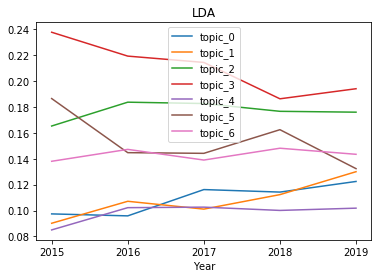

In [53]:
x = [2015, 2016, 2017, 2018, 2019]
plt.plot(plot_fuel.loc[:, 'topic_0'], data=plot_fuel)
plt.plot(plot_fuel.loc[:, 'topic_1'], data=plot_fuel)
plt.plot(plot_fuel.loc[:, 'topic_2'], data=plot_fuel)
plt.plot(plot_fuel.loc[:, 'topic_3'], data=plot_fuel)
plt.plot(plot_fuel.loc[:, 'topic_4'], data=plot_fuel)
plt.plot(plot_fuel.loc[:, 'topic_5'], data=plot_fuel)
plt.plot(plot_fuel.loc[:, 'topic_6'], data=plot_fuel)
plt.xlabel('Year')
plt.xticks(x)
plt.title('LDA')
plt.legend()

#### NMF plot of topics by year

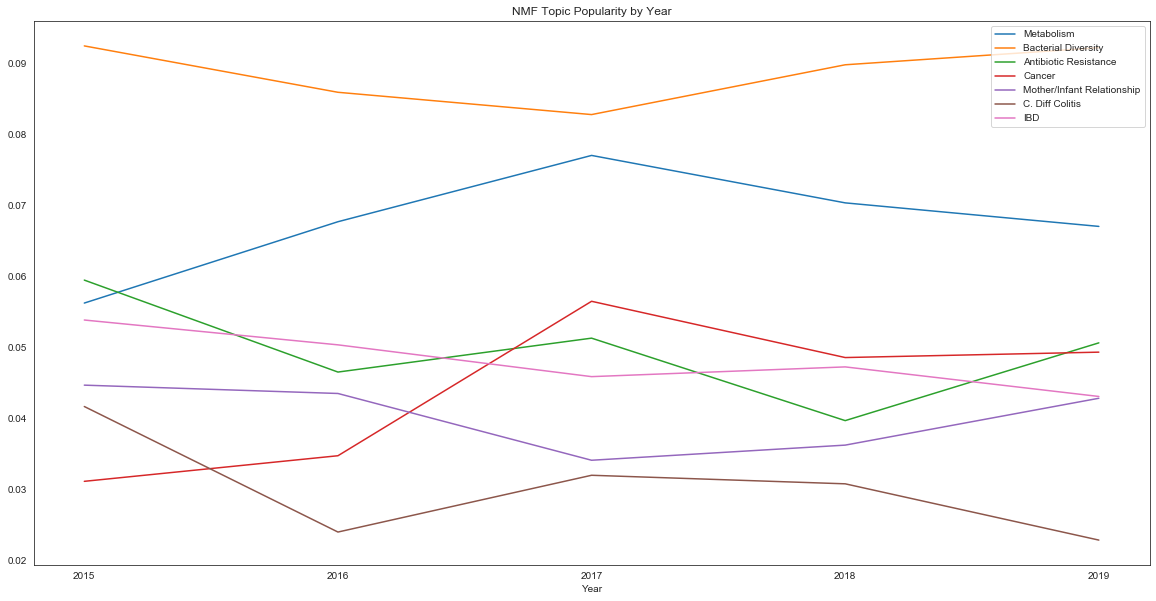

In [54]:
x = [2015, 2016, 2017, 2018, 2019]
sns.set_style("white")
plt.figure(figsize=(20,10))
plt.plot(plot_fuel2.loc[:, "Metabolism"], data=plot_fuel)
plt.plot(plot_fuel2.loc[:, "Bacterial Diversity"], data=plot_fuel)
plt.plot(plot_fuel2.loc[:, "Antibiotic Resistance"], data=plot_fuel)
plt.plot(plot_fuel2.loc[:, "Cancer"], data=plot_fuel)
plt.plot(plot_fuel2.loc[:, "Mother/Infant Relationship"], data=plot_fuel)
plt.plot(plot_fuel2.loc[:, "C. Diff Colitis"], data=plot_fuel)
plt.plot(plot_fuel2.loc[:, "IBD"], data=plot_fuel)
plt.xlabel('Year')
plt.xticks(x)
plt.title('NMF Topic Popularity by Year')
plt.legend()
plt.savefig('temp.png', transparent=True)

### PCA and Plotting to see if clusters form on 2 dimensions

In [212]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['b','orange','g','r','purple','brown','pink'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(8,8))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    #plt.legend(loc=2, prop={'size': 12})
    plt.savefig('pca.png', transparent=True)

In [180]:
target = list((J['Topic']).replace("Metabolism", 0)
              .replace("Bacterial Diversity", 1)
              .replace("Antibiotic Resistance", 2)
              .replace("Cancer", 3)
              .replace("Mother/Infant Relationship", 4)
              .replace("C. Diff Colitis", 5)
              .replace("IBD", 6))

In [189]:
pcafeatures_train[target == 1]

array([], shape=(0, 2500, 2), dtype=float64)

In [194]:
[np.array(target) == 1]

[array([False, False, False, ...,  True, False, False])]

In [181]:
corpus_df.head()

,0001,001,005,05,10,100,11,12,13,14,...,work,world,worldwide,would,year,years,yeast,yet,yield,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [188]:
pcafeatures_train.shape

(2500, 2)

In [182]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(corpus_df)
pcafeatures_train = pca.transform(corpus_df)

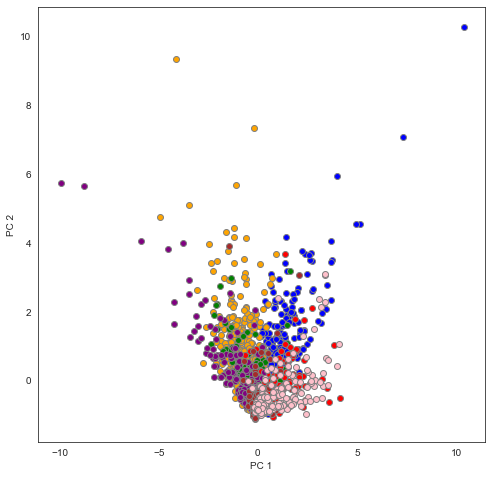

In [213]:
plot_PCA_2D(pcafeatures_train, target=np.array(target), target_names=["Metabolism","Bacterial Diversity","Antibiotic Resistance","Cancer",
                        "Mother/Infant Relationship","C. Diff Colitis","IBD"])

### Plotly plot Relative Word Frequency 2016 vs 2019

In [77]:
# Plotly based imports for visualization
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [78]:
corpus_16.sum(axis=0).sum()

23172

In [79]:
old_freq = corpus_16.sum(axis=0)/(corpus_16.sum(axis=0).sum())
new_freq = corpus_19.sum(axis=0)/(corpus_19.sum(axis=0).sum())

In [80]:
trace = go.Scattergl(
    x = old_freq,
    y = new_freq,
    mode = 'text',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    ),
    text = nlp.vectorizer.get_feature_names(),
    hovertext = nlp.vectorizer.get_feature_names(),
    hoverinfo = 'text' 
)
data = [trace]
iplot(data, filename='scatter-mode')